In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Añadir directorio raíz al path
sys.path.append(str(Path().resolve().parent))

from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, TARGET_COLUMN

# Cargar datos limpios (sin características adicionales)
df = pd.read_csv(INTERIM_DATA_DIR / "startup_data_clean.csv")

print("Información del dataset limpio:")
df.info()

Información del dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    float64
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                923 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    float64
 10  founded_at                923 non-null    object 
 11  closed_at                 923 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non

In [2]:
# Exploración de posibles características a crear
print("\nVerificando columnas disponibles para ingeniería de características...")
columns_by_type = {
    'Financiación': [col for col in df.columns if 'fund' in col.lower() or 'round' in col.lower()],
    'Tiempo/Edad': [col for col in df.columns if 'age' in col.lower() or 'year' in col.lower()],
    'Relaciones': [col for col in df.columns if 'relation' in col.lower()],
    'Ubicación': [col for col in df.columns if col.startswith('is_')],
    'Hitos': [col for col in df.columns if 'milestone' in col.lower()]
}

for category, cols in columns_by_type.items():
    print(f"\n{category}: {cols}")


Verificando columnas disponibles para ingeniería de características...

Financiación: ['first_funding_at', 'last_funding_at', 'age_first_funding_year', 'age_last_funding_year', 'funding_rounds', 'funding_total_usd', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']

Tiempo/Edad: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year']

Relaciones: ['relationships']

Ubicación: ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'is_top500']

Hitos: ['age_first_milestone_year', 'age_last_milestone_year', 'milestones']


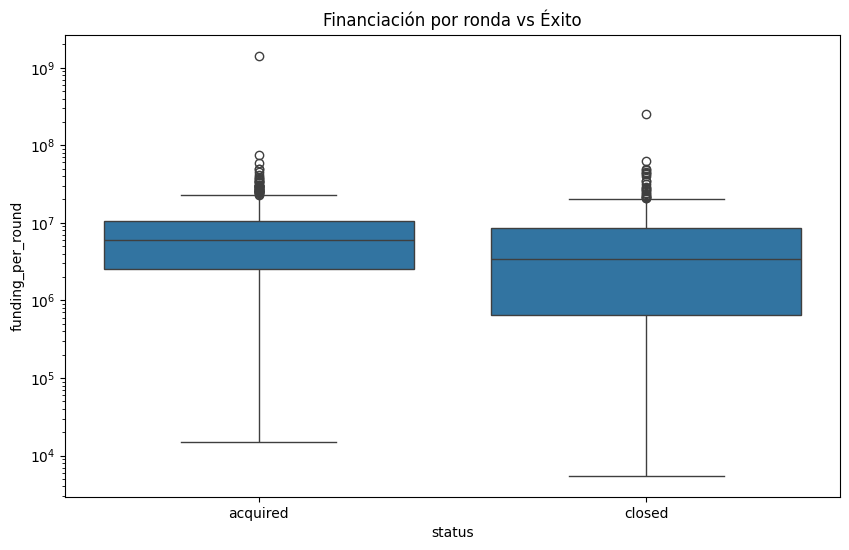


Estadísticas de financiación por ronda según éxito:
          count          mean           std      min           25%  \
status                                                               
acquired  597.0  1.069247e+07  5.863062e+07  14925.0  2.533333e+06   
closed    326.0  7.258446e+06  1.650597e+07   5500.0  6.512500e+05   

                   50%           75%           max  
status                                              
acquired  6.000000e+06  1.062500e+07  1.425000e+09  
closed    3.425714e+06  8.650008e+06  2.550000e+08  


In [4]:
#Análisis de características de financiación
if 'funding_total_usd' in df.columns and 'funding_rounds' in df.columns:
    # Crear característica de financiación por ronda
    df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds'].replace(0, 1)
    
    # Visualizar relación con el éxito
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=TARGET_COLUMN, y='funding_per_round', data=df)
    plt.title('Financiación por ronda vs Éxito')
    plt.yscale('log')
    plt.savefig('../reports/figures/feature_engineering/funding_per_round.png')
    plt.show()
    
    print(f"\nEstadísticas de financiación por ronda según éxito:")
    print(df.groupby(TARGET_COLUMN)['funding_per_round'].describe())

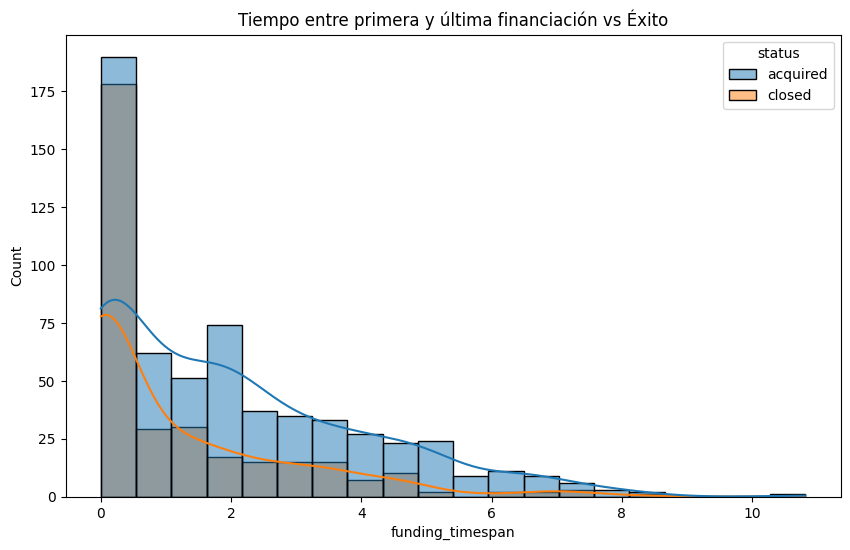


Estadísticas de duración de financiación según éxito:
          count      mean       std  min  25%     50%      75%      max
status                                                                 
acquired  597.0  1.997683  2.010627  0.0  0.0  1.5726  3.12880  10.8192
closed    326.0  1.143037  1.658751  0.0  0.0  0.0151  1.87055   8.1671


In [5]:
#Análisis de características temporales
if 'age_first_funding_year' in df.columns and 'age_last_funding_year' in df.columns:
    # Crear característica de duración de financiación
    df['funding_timespan'] = df['age_last_funding_year'] - df['age_first_funding_year']
    df['funding_timespan'] = df['funding_timespan'].apply(lambda x: max(0, x))
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='funding_timespan', hue=TARGET_COLUMN, bins=20, kde=True)
    plt.title('Tiempo entre primera y última financiación vs Éxito')
    plt.savefig('../reports/figures/feature_engineering/funding_timespan.png')
    plt.show()
    
    print(f"\nEstadísticas de duración de financiación según éxito:")
    print(df.groupby(TARGET_COLUMN)['funding_timespan'].describe())

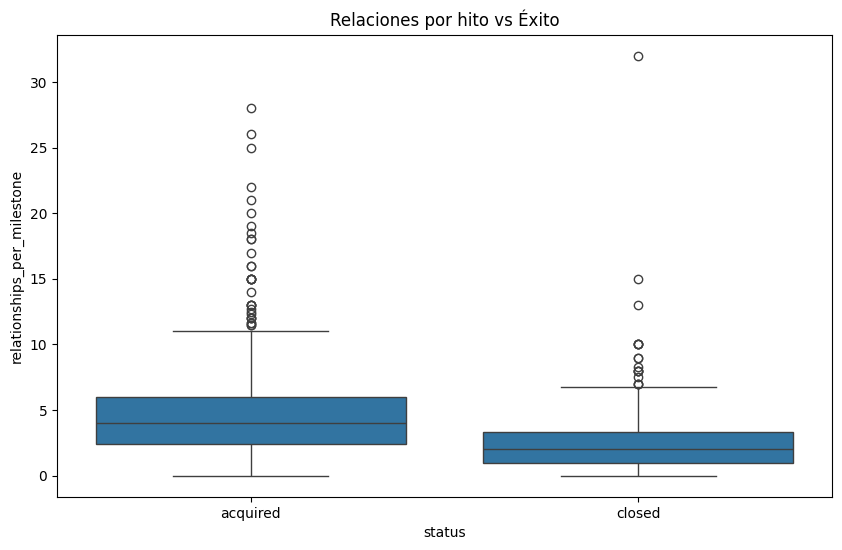


Estadísticas de relaciones por hito según éxito:
          count      mean       std  min  25%  50%       75%   max
status                                                            
acquired  597.0  4.772125  3.694490  0.0  2.4  4.0  6.000000  28.0
closed    326.0  2.694632  2.716461  0.0  1.0  2.0  3.333333  32.0


In [6]:
#Análisis de características de network
if 'relationships' in df.columns and 'milestones' in df.columns:
    # Crear ratio de relaciones por hito
    df['relationships_per_milestone'] = df['relationships'] / df['milestones'].replace(0, 1)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=TARGET_COLUMN, y='relationships_per_milestone', data=df)
    plt.title('Relaciones por hito vs Éxito')
    plt.savefig('../reports/figures/feature_engineering/relationships_per_milestone.png')
    plt.show()
    
    print(f"\nEstadísticas de relaciones por hito según éxito:")
    print(df.groupby(TARGET_COLUMN)['relationships_per_milestone'].describe())

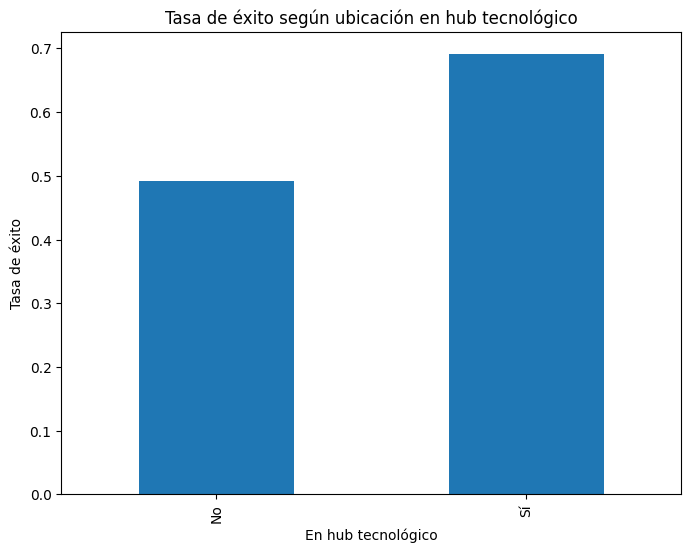


Tasa de éxito según ubicación en hub tecnológico:
in_tech_hub
0.0    0.492683
1.0    0.690808
Name: status_numeric, dtype: float64


In [11]:
# Análisis de características regionales
location_columns = [col for col in df.columns if col.startswith('is_')]
if location_columns:
    tech_hubs = ['is_CA', 'is_NY', 'is_MA', 'is_TX']  # Principales hubs tech en EE.UU.
    available_hubs = [hub for hub in tech_hubs if hub in df.columns]
    
    if available_hubs:
        df['in_tech_hub'] = df[available_hubs].max(axis=1)
        
        # Visualizar impacto de la ubicación en un hub tecnológico
        plt.figure(figsize=(8, 6))
        # 1 para 'acquired' (éxito) y 0 para 'closed' (fracaso)
        df['status_numeric'] = df[TARGET_COLUMN].apply(lambda x: 1 if x == 'acquired' else 0)
        # Crea una nueva columna numérica que representa la ubicación en un hub tecnológico
        # Luego usa esta columna numérica para calcular la media
        success_by_hub = df.groupby('in_tech_hub')['status_numeric'].mean()
        success_by_hub.plot(kind='bar')
        plt.title('Tasa de éxito según ubicación en hub tecnológico')
        plt.xlabel('En hub tecnológico')
        plt.ylabel('Tasa de éxito')
        plt.xticks([0, 1], ['No', 'Sí'])
        plt.savefig('../reports/figures/feature_engineering/tech_hub_success.png')
        plt.show()
        
        print(f"\nTasa de éxito según ubicación en hub tecnológico:")
        print(success_by_hub)


Correlación de nuevas características con el target:
- funding_per_round: 0.0341
- funding_timespan: 0.2111
- relationships_per_milestone: 0.2820
- in_tech_hub: 0.1723


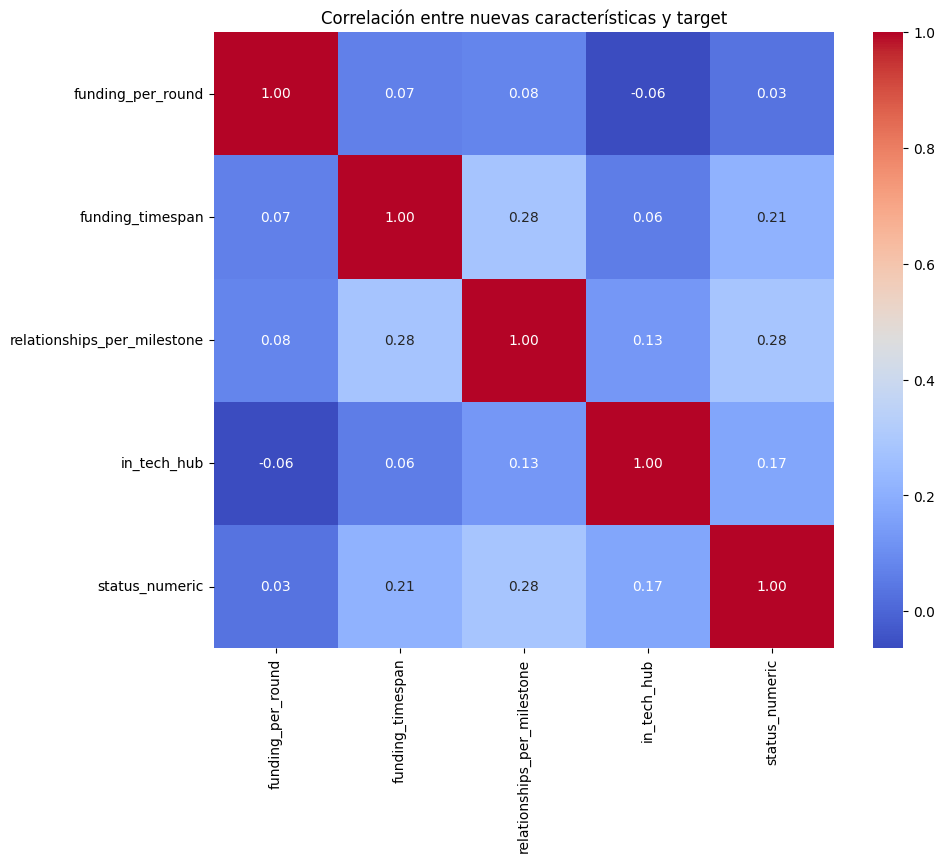

In [14]:
# Correlación de las nuevas características con el target
df['status_numeric'] = df[TARGET_COLUMN].apply(lambda x: 1 if x == 'acquired' else 0)

# Correlación de las nuevas características con el target
new_features = ['funding_per_round', 'funding_timespan', 'relationships_per_milestone', 'in_tech_hub']
available_features = [feat for feat in new_features if feat in df.columns]

if available_features:
    print("\nCorrelación de nuevas características con el target:")
    for feature in available_features:
        correlation = df[feature].corr(df['status_numeric'])  # Usar la versión numérica
        print(f"- {feature}: {correlation:.4f}")
    
    # Matriz de correlación de las nuevas características
    plt.figure(figsize=(10, 8))
    features_plus_target = available_features + ['status_numeric']  # Usar la versión numérica
    sns.heatmap(df[features_plus_target].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlación entre nuevas características y target')
    plt.savefig('../reports/figures/feature_engineering/new_features_correlation.png')
    plt.show()

In [15]:
# Guardar dataset con nuevas características para referencia
df_with_features = df.copy()
df_with_features.to_csv(INTERIM_DATA_DIR / "startup_data_with_new_features.csv", index=False)

print("\nResumen de ingeniería de características:")
print(f"- Características originales: {len(df.columns) - len(available_features)}")
print(f"- Nuevas características creadas: {len(available_features)}")
print(f"- Total características: {len(df.columns)}")


Resumen de ingeniería de características:
- Características originales: 50
- Nuevas características creadas: 4
- Total características: 54
